**Background**: When I started working on this kernel, I wanted to do some EDA and explore a few classification methods to see how I could achieve a decent score. Now that there are so many other excellent kernels out there with very high scores, I want to devote this kernel to shed some light one why some approaches worked better the others. I hope this will be useful for others who are confused by all these new records being set every other day in this competition. 

### Overview: 
We will start with linear classifiers like logistic regression and see why or why not they are better than blind guessing for this data and then go with more complicated classifiers. Emphasis would be in understanding the results of each iteration rather than getting the best performance. 

| Model  | Validation Set Accuracy   | Comments |  
|---|---|---|---|
| Blind Guessing  | 50%  |Based-line Model |
|  Logistic Regress with all columns as numeric | 52%    |   |  
|  Logistic Regression with one column as categorical | 51%  |   No Interactions between columns |  
|  Logistic Regression with one column as categorical, with interactions | 80%  |  With Interactions between columns |  

In [1]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings('ignore')

Let us first read the input data, and display the first few rows of the dataframes with titles. 

In [2]:
# Read the test and train data sets. 
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
print("Shapes of training and test datasets:");print(df_train.shape,df_test.shape)
print("Training Data Sample");display(df_train.head())
print("Test Data Sample");display(df_test.head())

Shapes of training and test datasets:
(262144, 258) (131073, 257)
Training Data Sample


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

Test Data Sample


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,1c13f2701648e0b0d46d8a2a5a131a53,-5.490030,0.593976,1.532732,-0.361234,-0.155282,-1.340582,1.626819,4.280084,-0.340155,-0.653070,2.817394,1.211543,-0.819354,-0.019935,0.634466,-1.604789,0.756771,0.451960,0.309252,-4.628353,-0.270163,-0.183827,0.099529,0.719685,-1.077965,-1.704726,0.263344,1.183083,-1.967262,-0.364729,-1.553005,0.667643,-1.647120,-0.118086,1.095897,-3.725086,0.571565,5.407131,1.599479,...,-0.007170,-0.723353,-0.317083,3.892687,0.732599,-0.829353,-1.281645,5.256029,0.484761,0.315440,-1.256456,-0.065537,0.243787,-0.085292,0.293226,-0.727176,-0.026991,-0.452266,1.733475,-0.511201,-0.913642,-2.237558,-1.607618,-0.497308,0.004124,-1.854472,1.499102,-0.701304,-0.573827,0.121455,0.386831,0.817764,-1.215121,0.238812,-0.507346,1.360599,-1.743894,1.412043,-0.562730,-0.237948
1,ba88c155ba898fc8b5099893036ef205,0.571698,0.495494,1.133975,-0.315875,-2.142458,-0.478650,-1.458941,0.977352,0.159189,0.425304,1.366214,-1.097810,-0.128929,-0.563375,-0.389307,-0.167991,0.314843,0.530220,-0.512497,0.526404,1.612939,-0.800211,0.692056,2.541566,0.290910,-0.726153,1.307040,0.964062,0.235339,3.553998,-0.769491,-1.706831,0.227793,-1.027914,1.359388,-1.296281,0.216550,0.166792,-1.361746,...,8.867017,0.145251,-2.429107,-1.994984,0.692641,-0.922336,-0.442788,-0.357402,0.606270,-0.144259,-0.019312,0.132073,-1.038829,-0.361597,-0.019181,0.656320,-0.029080,-0.263428,-1.674349,0.237658,-0.539413,3.683862,0.341788,0.321800,1.919056,-0.680074,-0.851474,-0.802017,1.984299,0.606214,-1.120400,-0.953432,0.266619,-2.088512,0.252637,-1.034676,-0.804765,0.639112,1.172667,-1.666513
2,7cbab5cea99169139e7e6d8ff74ebb77,0.478202,-1.429985,0.41

**It looks like the data is mostly numerical, with random column names, and we need to predict the "target" column**.

**Let us also make sure the training and test column names are same, other than the target column**

In [4]:
# The following will be true if the column names in the training and test data sets are identical
set(df_train.columns[df_train.columns != 'target']) == set(df_test.columns)

True

**Next step is too look at distributions of various columns in the test and training data sets. You have to scroll from left right to see all the columns.**

In [5]:
print("Training Data Summary");df_train.describe()

Training Data Summary


,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000
mean,0.005924,0.000936,-0.012530,-0.005688,0.001607,0.007878,-0.003500,-0.005927,0.002664,0.020485,-0.001629,0.008115,-0.001445,0.006434,0.013150,-0.016462,0.014498,0.000990,-0.004702,-0.010490,0.006592,-0.007705,0.010857,-0.011858,-0.005172,-0.012855,-0.003606,0.001209,0.007980,-0.005911,-0.000397,-0.000490,-0.013010,-0.000040,0.003882,-0.008507,-0.009352,0.007037,0.004091,-0.011576,...,-0.002381,-0.010963,0.005069,0.001779,0.011217,-0.000718,-0.008141,0.003521,0.011593,-0.011187,0.001626,0.000656,0

In [6]:
print("Test Data Summary");df_test.describe()

Test Data Summary


,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
count,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,...,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000
mean,0.000717,-0.001042,-0.014509,-0.007666,0.003343,0.001975,-0.003154,-0.003252,-0.000867,0.021517,0.008928,-0.001051,-0.006368,-0.002891,0.010515,-0.023823,0.000880,0.003780,-0.009165,-0.000505,0.011933,-0.003440,0.005804,0.003148,-0.016712,-0.009732,-0.002171,0.001297,0.009926,-0.003764,-0.003134,-0.010153,-0.014269,-0.000145,0.003224,-0.012756,-0.003288,0.000392,0.006548,-0.012575,...,0.006470,-0.010495,-0.008946,0.008752,0.002811,0.020735,-0.002210,-0.009315,0.007151,0.007063,-0

**It looks like all the training and test, columns are very similar in distribution with mean value of about 0, and standard deviation of about 1.7 **
**Let us confirm that by looking at distbrutions of 16 randomly sampled columns**

Text(0.5, 1.0, 'Distribution of features in the Training Set (Sample of 16 features)')

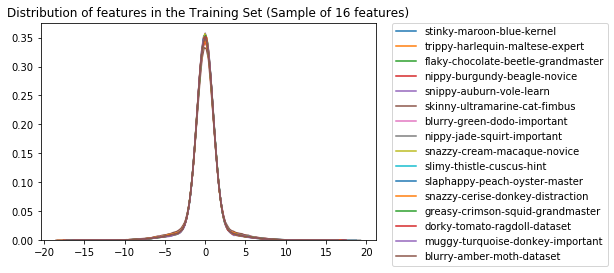

In [7]:
fig, ax = plt.subplots()
random_cols = np.random.choice(range(1,df_train.shape[1]-1),16)
for col in df_train.columns[random_cols]:
    sns.kdeplot(df_train[col], ax = ax)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Distribution of features in the Training Set (Sample of 16 features)')

**Great, we can see tha the distributions of the variables are very close to each other, centered around zero. There shouldn't be much need for normalizing the variables. ** 


**Let us also look at the test set to make sure.**

Text(0.5, 1.0, 'Distribution of features in the Test Set (Sample of 16 features)')

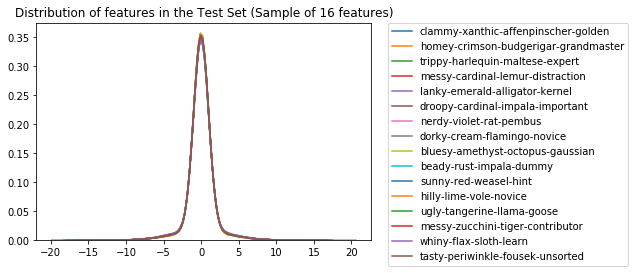

In [8]:
fig, ax = plt.subplots()
random_cols = np.random.choice(range(1,df_test.shape[1]),16)
for col in df_test.columns[random_cols]:
    sns.kdeplot(df_train[col], ax = ax)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Distribution of features in the Test Set (Sample of 16 features)')

**It was identified by others that wheezy-copper-turtle-magic appears to be a categorical variable, with a distribution that is diferent from rest of the variables**. How do we go about finding such a thing ? 

Since we expected all the columns to have similar median / standard deviation values, let us plot all the medians vs. standard deviations to see if we can find an outliers. 


Text(0.5, 1.0, 'Medians vs. Standard Deviations of all the columns in the training data')

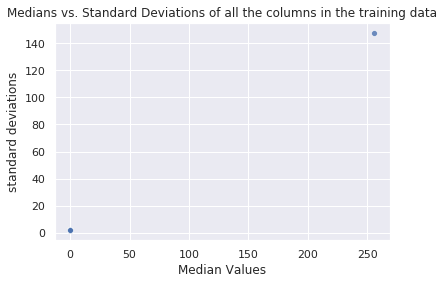

In [9]:
sns.set()
ax = sns.scatterplot(
    x = df_train.loc[:,(df_train.columns != 'target') & (df_train.columns != 'id') ].median(axis = 0),
    y = df_train.loc[:,(df_train.columns != 'target') & (df_train.columns != 'id') ].std(axis = 0), alpha = 0.8)
ax.set(xlabel='Median Values', ylabel='standard deviations')
plt.title('Medians vs. Standard Deviations of all the columns in the training data')

We can clearly see that there are one or more points with Median value close to 250 and standard deviation close to 140. Let us filter these columns to figure out what they are. 

In [10]:
median_vals = df_train.loc[:,(df_train.columns != 'target') & (df_train.columns != 'id') ].median(axis = 0)
median_vals[median_vals > 100]

wheezy-copper-turtle-magic    256.0
dtype: float64

We can see from the above that only "wheezy-copper-turtle-magic" is the outlier column. Let us take a look at its distribution. We can see that its distribution is signficantly different from other columns

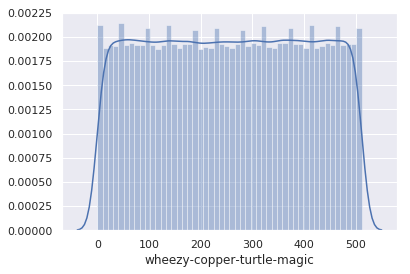

In [11]:
col = 'wheezy-copper-turtle-magic'
sns.distplot(df_train[col])

# Comparing Various Models:

## Model 0: Blind guessing


Let us first divide the data and training and validation data sets

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns = ['id','target']),df_train['target'], test_size=0.15, random_state=2)

Let us first start with the blind guess model where we select each row as either 1 or 0 randomly. Based on the disribution of the target variable as shown below, we expect about 50% accuracy for the blind guess model. 

Text(0.5, 1.0, 'Distribution of target variable in the training data')

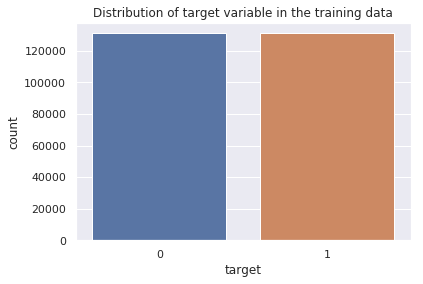

In [13]:
sns.countplot(df_train['target'])
plt.title('Distribution of target variable in the training data')

In [14]:
# Randomly choose either True or False for each row. 
y_blind_guess = np.random.randint(2, size = len(y_val))
print("Accuracy with blind guessing: %.2f" % accuracy_score(y_val, y_blind_guess, normalize=True))

Accuracy with blind guessing: 0.50


**As expected, blind guessing gave us a 50% accuracy based on the distribution of the data. Let us see how quickly we can improve the score beyond the 50%.**

## Model 1: Logistic Regression with all features considered as numerical columns
Let us first start with a linear model for logistic regression using all the features

In [15]:
logreg = LogisticRegression().fit(X_train,y_train)
#y_pred = logreg.predict(X_val)
print("Accuracy of logisic Regression on Validation Set: %.2f" % logreg.score(X_val, y_val))

Accuracy of logisic Regression on Validation Set: 0.52


**So, our model got a 52% accuracy. That is very slightly better than blind guessing, which should give us 50% accuracy as seen in the previous guess. There is lot of room for improvement !**

### Question 1: Why did our logistic regression give only 2% improvement on the baseline blind guess model ? 

Other than saying that probably the data (without any feature engineering) didn't have a clear linear correlation with the target variable, we cannot conclude much at this point. But for a better understanding, let us take a look at how target variable is encoded with respect to a few randomly selected columns. 

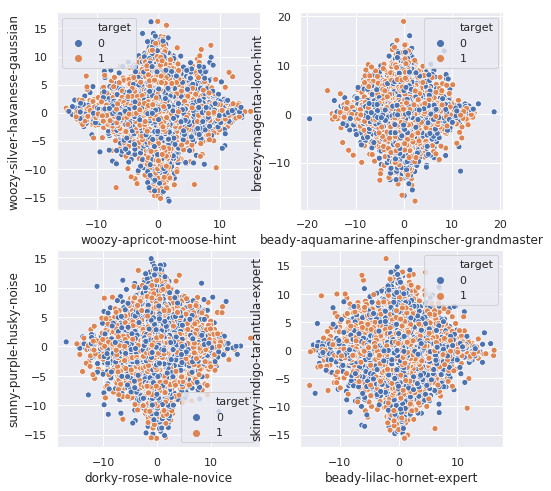

In [18]:
fig, axs = plt.subplots(ncols = 2 ,nrows=2, figsize=(8,8))
random_cols = df_train.columns[np.random.choice(range(1,df_train.shape[1]-1),8)]
sns.scatterplot(x = random_cols[0], y = random_cols[1], hue = 'target', data = df_train, ax=axs[0,0])
sns.scatterplot(x = random_cols[2], y = random_cols[3], hue = 'target', data = df_train, ax=axs[0,1])
sns.scatterplot(x = random_cols[4], y = random_cols[5], hue = 'target', data = df_train, ax=axs[1,0])
sns.scatterplot(x = random_cols[6], y = random_cols[7], hue = 'target', data = df_train, ax=axs[1,1])

From the above we can imagine that it might be hard to classify the target variable based on the linear combinations of the columns. 

## Model 1: Logistic regression with wheezy-copper-turtle-magic as a categorical variable

As mentioned earlier, it was identified by others that wheezy-copper-turtle-magic appears to be a categorical variable, with a distribution that is diferent from rest of the variables, so converting it to a categorical, column and using one-hot encoding might help improve accuracy. 

Before we convert this column to a categorical column, let us first make sure all the values of this column in the test data are a subset of this column's values in the training data

In [19]:
set(df_test['wheezy-copper-turtle-magic']) - set(df_train['wheezy-copper-turtle-magic'])

set()

Above operation shows that the column "wheezy-copper-turtle-magic", doesn't take any additional values in the test data. 

In [20]:
df_train_2 = pd.get_dummies(df_train, columns = ['wheezy-copper-turtle-magic'], prefix='wctm-')
df_test_2 = pd.get_dummies(df_test, columns = ['wheezy-copper-turtle-magic'], prefix='wctm-')
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(df_train_2.drop(columns = ['id','target']),df_train_2['target'], test_size=0.15, random_state=2)

In [21]:
logreg_2 = LogisticRegression().fit(X_train_2,y_train_2)
#y_pred = logreg.predict(X_val)
print("Accuracy of logisic Regression on Validation Set: %.2f" % logreg_2.score(X_val_2, y_val_2))

Accuracy of logisic Regression on Validation Set: 0.51


### Question2 : Why did changing the "wheezy-copper-turtle-magic" to categorical didn't improve the accuracy as we were expecting ?

**Answer**: As mentioned in this discussion post (https://www.kaggle.com/c/instant-gratification/discussion/92930#latest-537424), it looks like the data consists of several subsets each of which is indicated by a value of the "wheezy-copper-turtle-magic" column. Sometimes changing such a column to category will be enough, but some times, we have to develop a separate model for each of the values in the category. 

For example if you are developing a pricing model for a store that sells groceries and antique items, one can imagine that antiques will have a completely different price vs. age model, compared to perishable items. So, just having the item category as a categorical variable is not enough, we need to have a separate model for each category. 



So, as highlighted in Chris's excellent Kernel here: https://www.kaggle.com/cdeotte/logistic-regression-0-800, let us build a logistic regression model for each category to see if that improves the score significantly. 

In [22]:
# Code from: https://www.kaggle.com/cdeotte/logistic-regression-0-800
    
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

cols = [c for c in train.columns if c not in ['id', 'target']]
oof = np.zeros(len(train))
skf = StratifiedKFold(n_splits=5, random_state=42)

# INITIALIZE VARIABLES
cols.remove('wheezy-copper-turtle-magic')
interactions = np.zeros((512,255))
oof = np.zeros(len(train))
preds = np.zeros(len(test))

# BUILD 512 SEPARATE MODELS
for i in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    test2.reset_index(drop=True,inplace=True)
    
    skf = StratifiedKFold(n_splits=25, random_state=42)
    for train_index, test_index in skf.split(train2.iloc[:,1:-1], train2['target']):
        # LOGISTIC REGRESSION MODEL
        clf = LogisticRegression(solver='liblinear',penalty='l1',C=0.05)
        clf.fit(train2.loc[train_index][cols],train2.loc[train_index]['target'])
        oof[idx1[test_index]] = clf.predict_proba(train2.loc[test_index][cols])[:,1]
        preds[idx2] += clf.predict_proba(test2[cols])[:,1] / 25.0
        # RECORD INTERACTIONS
        for j in range(255):
            if clf.coef_[0][j]>0: interactions[i,j] = 1
            elif clf.coef_[0][j]<0: interactions[i,j] = -1
    #if i%25==0: print(i)
        
# PRINT CV AUC
auc = roc_auc_score(train['target'],oof)
print('LR with interactions scores CV =',round(auc,5))

LR with interactions scores CV = 0.80549


We can see that the accuracy greatly improved once we identified that we needed to have separate models for each category, and that just having the "magic" column as a categorical column was not enough. 

### Model 3: Neural Network (in-progress)

Let us try a neural network with Tensorflow, to see if we can achieve better accuracy. 


**Note:** Some of this model was inspired by: https://www.kaggle.com/dimitreoliveira/instant-gratification-deep-learning

In [ ]:
nn_model = keras.Sequential([
    keras.layers.Dense(1024, input_dim = X_train_2.shape[1]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer= 'adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
nn_model.summary()

In [ ]:
nn_history = nn_model.fit(X_train_2.values, y_train_2.values,
                                  epochs=5,
                                  batch_size=128,
                                  validation_data=(X_val_2.values, y_val_2.values),
                                  verbose=2)

**It looks like our neural network model is giving better accuracy than the simple logistic regression/random forest models**

## Let us submit the best model so far

In [23]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)